In [3]:
import re
import pandas as pd
import time
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor

import pickle 
import math as m
import random as r
import numpy as np


In [1]:
! git clone https://github.com/SZTankWang/ml-weibo-project-.git

Cloning into 'ml-weibo-project-'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 60 (delta 18), reused 43 (delta 8), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [4]:
df = pd.read_excel("ml-weibo-project-/data/raw_data.xlsx",skiprows=1,usecols=["微博正文","点赞数","转发数","评论数"])
df.head()

,微博正文,点赞数,转发数,评论数
0,【#你好，明天#】岁末年初，即便你的年终盘点一言难尽，但新年的flag仍然计日可期。需要抓住...,5389,1997,406
1,【今天，发条微博，向这些“闪亮的名字”致敬】南仁东、林俊德、张超、王继才、黄群、宋月才、姜开...,6826,1268,289
2,【夜读：这一年，谢谢自己】转眼间，2018年就要过去了。有时候我们很怕，怕自己的成长速度跟不...,6565,4326,580
3,【小调查：跨年夜，你如何度过的？】#2018最后一天#，你是如何度过的？陪在家人身边？宅在家...,919,2562,5281
4,【揭秘！习主席书架上的新变化】今晚，习近平主席发表了#2019新年贺词#。这一次，习主席书架...,6513,1758,440


In [5]:
df = df.rename(columns = {'微博正文':'text', '点赞数':'like', '转发数':'comment','评论数':'forward'}, inplace=False)
df.head()

,text,like,comment,forward
0,【#你好，明天#】岁末年初，即便你的年终盘点一言难尽，但新年的flag仍然计日可期。需要抓住...,5389,1997,406
1,【今天，发条微博，向这些“闪亮的名字”致敬】南仁东、林俊德、张超、王继才、黄群、宋月才、姜开...,6826,1268,289
2,【夜读：这一年，谢谢自己】转眼间，2018年就要过去了。有时候我们很怕，怕自己的成长速度跟不...,6565,4326,580
3,【小调查：跨年夜，你如何度过的？】#2018最后一天#，你是如何度过的？陪在家人身边？宅在家...,919,2562,5281
4,【揭秘！习主席书架上的新变化】今晚，习近平主席发表了#2019新年贺词#。这一次，习主席书架...,6513,1758,440


In [6]:
f = open("ml-weibo-project-/data/tfidf.txt", 'r',encoding="utf8")
allsentences = f.readlines()

for i in range(len(allsentences)):
  allsentences[i] = allsentences[i].strip('\n')
y = df[['like','comment','forward']]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(allsentences, y, train_size=.7, test_size=.3, random_state=0, shuffle=True, stratify=None)
f.close()

In [22]:
print(y_train.loc[y_train["forward"]==0])

       like  comment  forward
10202     0        0        0
30732     0        0        0
58647     0        0        0
30248   425      184        0
62359     0        0        0
...     ...      ...      ...
34897  2237      433        0
73255     0        0        0
10194     0        0        0
20177  1447      519        0
49747     0        0        0

[346 rows x 3 columns]


In [5]:
y_train.loc[[10202]]

,like,comment,forward
10202,0,0,0


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频
vectorizer = CountVectorizer(max_features=100000)
#该类会统计每个词语的tf-idf权值
tf_idf_transformer = TfidfTransformer()
#将文本转为词频矩阵并计算tf-idf
X_train = tf_idf_transformer.fit_transform(vectorizer.fit_transform(X_train))

# normalize y_train, y_test
y_train = np.log(y_train)
print(type(y_train))
y_train = y_train.replace(-np.Inf,0)
y_test = np.log(y_test)

y_test = y_test.replace(-np.Inf,0)



<class 'pandas.core.frame.DataFrame'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


In [7]:
y_train.loc[[10202]]

,like,comment,forward
10202,0.0,0.0,0.0


In [9]:
model = RandomForestRegressor(n_estimators=150,max_depth=20, random_state=0)

model.fit(X_train,y_train)

print("training done")

training done


In [10]:
y_pred = model.predict(X_train)


print("MAE ON TRAINING SET BEFORE TAKING EXPONENTIAL: ",mean_absolute_error(y_train.values, y_pred,multioutput="raw_values"))
print("MAE ON TRAINING SET AFTER TAKING EXPONENTIAL: ",mean_absolute_error(np.exp(y_train.values), np.exp(y_pred),multioutput="raw_values"))

X_test = tf_idf_transformer.transform(vectorizer.transform(X_test))
y_pred_test = model.predict(X_test)

print("MAE ON TESTING SET BEFORE TAKING EXPONENTIAL: ",mean_absolute_error(y_test.values, y_pred_test,multioutput="raw_values"))
print("MAE ON TESTING SET AFTER TAKING EXPONENTIAL: ",mean_absolute_error(np.exp(y_test.values), np.exp(y_pred_test),multioutput="raw_values"))


MAE ON TRAINING SET BEFORE TAKING EXPONENTIAL:  [1.12319289 0.72993204 0.7665977 ]
MAE ON TRAINING SET AFTER TAKING EXPONENTIAL:  [11004.5874486   4918.86775181  1165.77679719]
MAE ON TESTING SET BEFORE TAKING EXPONENTIAL:  [1.22716085 0.79956614 0.85020987]
MAE ON TESTING SET AFTER TAKING EXPONENTIAL:  [11702.07836839  5199.42832755  1195.86436983]


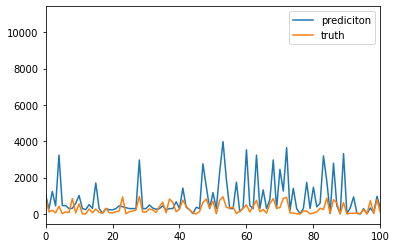

In [11]:
# y_pred.shape
# y_train.shape

# diff = np.absolute(np.subtract(np.exp(y_train),np.exp(y_pred)))
# diff

# find observations with likes less than 1000
import matplotlib.pyplot as plt

mask = np.exp(y_train).values[:,0]<=1000
# np.exp(y_train).values[mask,:]
# print(type(y_pred))
y_train_masked = np.exp(y_train.values)[mask,[0]] 
y_pred_masked = np.exp(y_pred)[mask,[0]]
y_pred_masked.shape[0]

# draw a plot
x_axis = np.arange(0,y_pred_masked.shape[0],1)
plt.plot(x_axis,y_pred_masked,label="prediciton")
plt.plot(x_axis,y_train_masked,label="truth")
plt.xlim([0, 100])
plt.legend()
plt.show()

In [12]:
test_text = "你好 明天 岁末 年初 年终 盘点 一言难尽 新年 flag 仍然 计日可期 需要 抓住 联结 历史 未来 每一个 当下 今日 胜 昨日 奋斗 唯一 解 一时 千载千载 一时 面对 未来 值得 庆幸 努力 奔跑 都是 追梦人 再见 2018 你好 2019 原图"
x_test = [test_text]
x_test = tf_idf_transformer.transform(vectorizer.transform(x_test))
y_result = model.predict(x_test)
y_result = np.exp(y_result)
y_result

array([[2772.14965593, 1131.95397659,  761.29881812]])

In [15]:
# pickle.dump(model,open('randomForest.pkl','wb'))
! 

fatal: not a git repository (or any of the parent directories): .git
